# Contraceptive Demand Forecasting 

Demand forecasting of contraceptive products in Côte d’Ivoire.

### Dataset: 
Monthly data of 11 contraceptive products stock across 156 health service delivery sites in the public sector health system in Côte d’Ivoire, from January 2016 until June 2019.

### Goal:
Forecast contraceptives' stock demand for July, August and September of 2019.

#### Author: Bruna Correa

In [1]:
# Import general libraries
import pandas as pd
import numpy as np
from numpy.random import seed
from matplotlib import pyplot as plt
from matplotlib import dates
import seaborn as sns

# Import classical forecasting libraries
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima import auto_arima

# Import neural network libraries
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set sns style
sns.set(style="ticks", color_codes=True)

In [2]:
# Load and check dataset of contraceptives' stock:
stock_df = pd.read_csv('/data/Train.csv')
print(f'Total number of rows: {stock_df.shape[0]}')
print(f'Total number of columns: {stock_df.shape[1]}')
stock_df.head()

Total number of rows: 35753
Total number of columns: 14


,year,month,region,district,site_code,product_code,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_stockout_days,stock_ordered
0,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,75,0,21,-54,0,18,0,100.0
1,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27132,3,0,3,0,0,2,0,10.0
2,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27000,0,75,22,0,53,9,0,0.0
3,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27137,2,0,0,0,2,0,0,0.0
4,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27138,45,0,2,0,43,1,0,0.0


In [3]:
# Features information:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35753 entries, 0 to 35752
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         35753 non-null  int64  
 1   month                        35753 non-null  int64  
 2   region                       35753 non-null  object 
 3   district                     35753 non-null  object 
 4   site_code                    35753 non-null  object 
 5   product_code                 35753 non-null  object 
 6   stock_initial                35753 non-null  int64  
 7   stock_received               35753 non-null  int64  
 8   stock_distributed            35753 non-null  int64  
 9   stock_adjustment             35753 non-null  int64  
 10  stock_end                    35753 non-null  int64  
 11  average_monthly_consumption  35753 non-null  int64  
 12  stock_stockout_days          35753 non-null  int64  
 13  stock_ordered   

In [4]:
# Subselect features that will be used for EDA and forecasting:
stock_df_sel = stock_df[['year',
                         'month',
                         'region',
                         'district',
                         'site_code',
                         'product_code',
                         'stock_distributed']].copy()

* Target variable: 'stock_distributed'.

## Exploratory Data Analysis

In [5]:
# Check for missing values:
stock_df_sel.isnull().mean().sort_values()

year                 0.0
month                0.0
region               0.0
district             0.0
site_code            0.0
product_code         0.0
stock_distributed    0.0
dtype: float64

* No missing values.

In [6]:
# Summarize stock_distributed variable:
stock_df_sel['stock_distributed'].describe()

count    35753.000000
mean        14.764327
std         39.848242
min          0.000000
25%          0.000000
50%          1.000000
75%         13.000000
max       1728.000000
Name: stock_distributed, dtype: float64

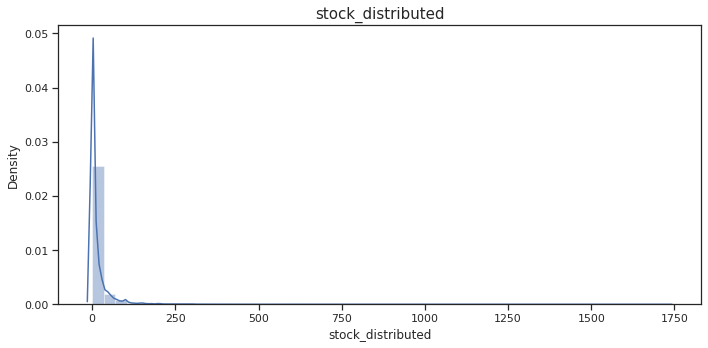

In [7]:
# Plot distribution of stock_distributed variable:
plt.figure(figsize=(10, 5))
sns.distplot(a=stock_df_sel['stock_distributed'])
plt.title('stock_distributed', fontsize=15)
plt.tight_layout()

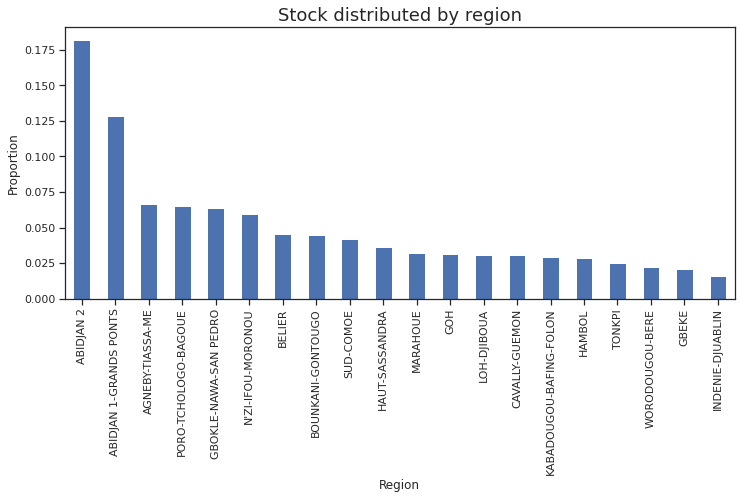

In [8]:
# Explore target by region:
stock_df_sel['region'].value_counts(normalize=True).plot(kind='bar', figsize=(12, 5))
plt.title('Stock distributed by region', size=18)
plt.xlabel('Region')
plt.ylabel('Proportion')
plt.show()

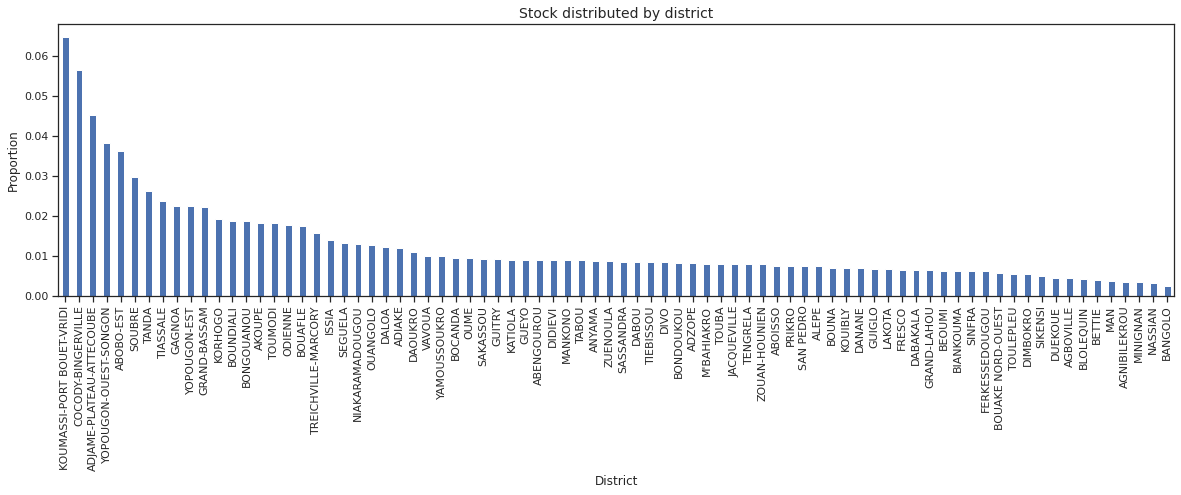

In [9]:
# Explore target by district:
stock_df_sel['district'].value_counts(normalize=True).plot(kind='bar', figsize=(20, 5))
plt.title('Stock distributed by district', size=14)
plt.xlabel('District')
plt.ylabel('Proportion')
plt.show()

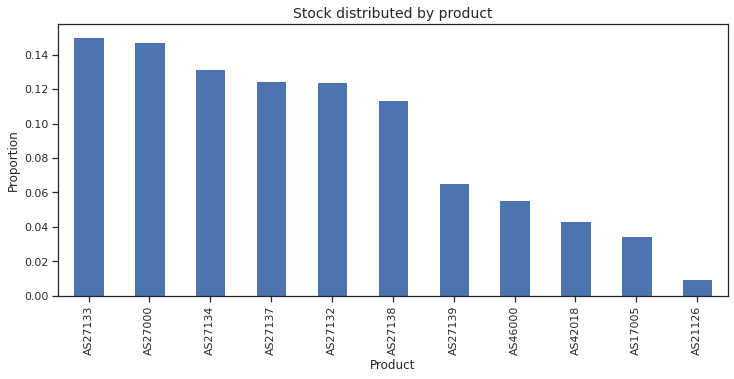

In [10]:
# Explore product's distribution:
stock_df_sel['product_code'].value_counts(normalize=True).plot(kind='bar', figsize=(12, 5))
plt.title('Stock distributed by product', size=14)
plt.xlabel('Product')
plt.ylabel('Proportion')
plt.show()

### Temporal EDA

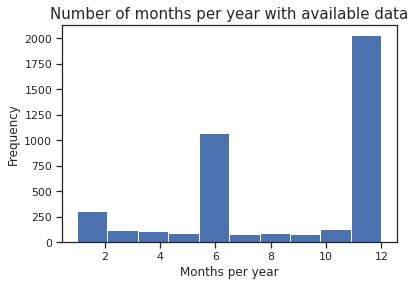

In [11]:
# Group by site_code, product_code, year, to check time range completeness:
stock_df_sel.groupby(['site_code', 'product_code', 'year']).nunique()['month'].plot(kind='hist')
plt.xlabel('Months per year')
plt.title('Number of months per year with available data', fontsize=15);

* There are missing months for some combinations of site_code + product_code.
* Peak at 6 months: for 2019 we only have data until June.
* To do: populate missing months from Jan-2016 until Jun-2019 and impute values.

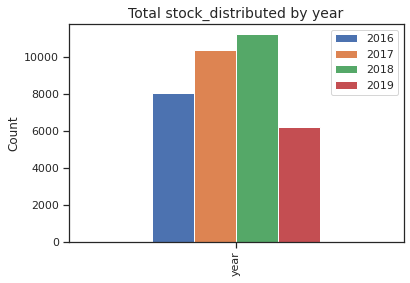

In [12]:
# Plot total stock distributed by year:
ax = stock_df_sel['year'].value_counts(normalize=False).sort_index().to_frame().transpose().plot.bar()
ax.set_title('Total stock_distributed by year', fontsize=14)
ax.set_ylabel('Count');

* Distributed stock shows an increase across time from 2016 to 2018.
* 2019 doesn't have data for all 12 months.

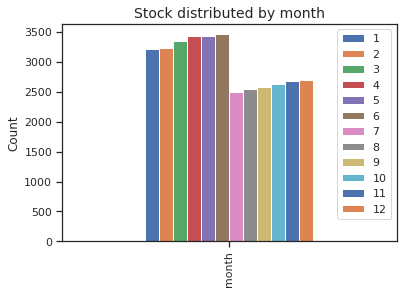

In [13]:
# Plot total stock distributed by month:
ax = stock_df_sel['month'].value_counts(normalize=False).sort_index().to_frame().transpose().plot.bar()
ax.set_title('Stock distributed by month',fontsize=14)
ax.set_ylabel('Count');

* For the first 6 months, distributed stock shows an increase across time.
* For the last 6 months, we don't have data from 2019, but the same trend seems to occur.

In [14]:
# Check 2019 data to confirm its month range:
stock_df_sel[stock_df_sel['year']==2019]['month'].value_counts(normalize=False).to_frame().sort_index()

,month
1,1014
2,1002
3,1006
4,1068
5,1052
6,1032


* For 2019, there are data only until June.

In [15]:
# Create a datetime formated index for time series analyses:
idx = pd.to_datetime(
    dict(
        year=stock_df_sel['year'], 
        month=stock_df_sel['month'], 
        day=1 # as we don't have information about the day, fill it with ones
    )
)
# Set dataframe index
stock_df_sel.set_index(idx, inplace=True)

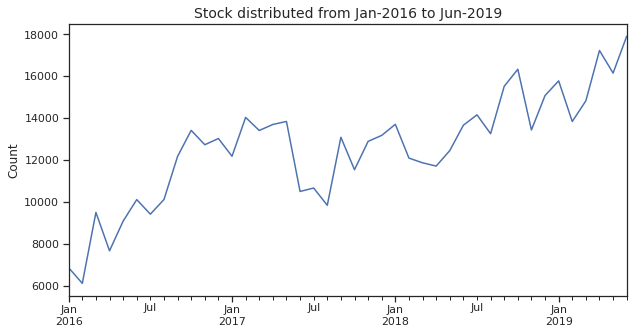

In [16]:
# Plot total stock distributed from 2016 to 2019:
ax = stock_df_sel.groupby(stock_df_sel.index)['stock_distributed'].sum().plot(figsize=(10,5))
ax.set_title('Stock distributed from Jan-2016 to Jun-2019', fontsize=14)
ax.set_ylabel('Count');

* There is a linear uptrend.
* Trend was disrupted in the middle of 2017.

In [17]:
# Format data frame to plot:
monthly = stock_df_sel.resample('M').sum()
monthly['month'] = monthly.index.month
monthly['year'] = monthly.index.year
pv = monthly.pivot('month', 'year', 'stock_distributed')

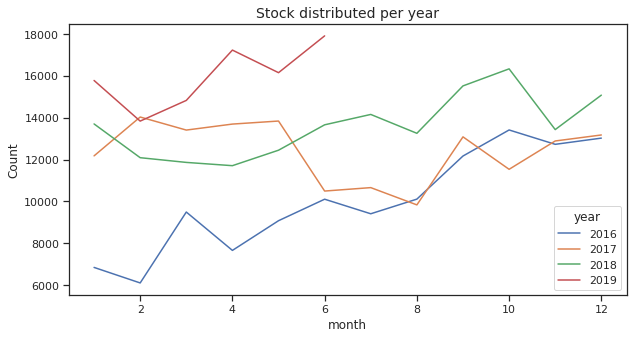

In [18]:
# Plot total stock distributed per year:
ax = pv.plot(figsize=(10,5))
ax.set_title('Stock distributed per year', fontsize=14)
ax.set_ylabel('Count');

* In 2017 from May to August there was an overall decline in the stock distributed.

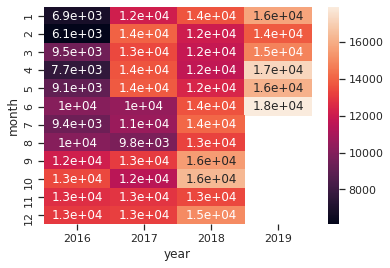

In [19]:
# Plot temporal heatmap:
sns.heatmap(pv, annot=True);

* Alternative visualization, similar message:
    * stock_distribution increased from Jan-2016 until Jun-2019;
    * there was a decline in 2017 (May - Aug).

## Feature engineering

* For some combinations of site_code/product, there are missing dates.
* To do: populate missing dates and impute values for stock_distributed.

In [20]:
# 1) Define function to populate missing months from Jan-2016 until Jun-2019:

def get_ts_range(input_df, date_start, date_end, date_freq):
    
    # Sort data frame by index:
    input_df.sort_index(inplace=True)
    
    # Create an index with every month in the range from Jan-2016 until Jun-2019:
    idx_date = pd.date_range(start=date_start, end=date_end, freq=date_freq)
    
    # Create a new data frame with complete dates and impute it with zeros:
    ts_df = pd.DataFrame(np.zeros(len(idx_date)), index=idx_date)
    
    # Rename col:
    ts_df.columns = ['imputation_col']
    
    # Concatenate input data frame with complete data frame:
    ts_df_comp = pd.concat([ts_df, input_df], axis=1, sort=False)
        
    # Return data frame with complete range:
    return ts_df_comp

In [21]:
# 2) Define function to impute values in created months:
    
def impute_date_vals(input_df, cat_feat_list, target_feat):
    
    # 1) Impute missing values of stock_distributed with interpolation:
    input_df[target_feat].interpolate(method='linear', inplace=True)
    
    # 2) Impute missing values from begining of time series with back propagation:
    input_df[target_feat].fillna(inplace=True, method='bfill')

    # 3) Impute missing values from end of time series with forward propagation:
    input_df[target_feat].fillna(inplace=True, method='ffill')
    
    # 4) Impute missing values of categorical features (region, district, site_code, product_code) with mode:
    input_df[cat_feat_list] = input_df[cat_feat_list].fillna(input_df.mode().iloc[0])
     
    # 5) Return complete data frame with desired features
    return input_df[cat_feat_list+[target_feat]]

In [22]:
# 3) Define function to fill and impute individual time series (site_code & product_code):

def get_complete_df(input_df, date_start, date_end, date_freq, cat_feat_list, target_feat):
    
    # Create output place holder df
    df_complete = pd.DataFrame()
    
    # Loop over data frame and get every 'site_code' & 'product_code' combinations:
    for site, product in input_df.groupby(['site_code','product_code']).indices:
        
        # Create a dataframe for each time series:
        single_ts_df = input_df[(input_df['site_code'] == site) & (input_df['product_code'] == product)]
        
        # Add missing months:
        single_ts_df_complete_dates = get_ts_range(single_ts_df, 
                                                   date_start, 
                                                   date_end, 
                                                   date_freq)
        
        # Impute missing values:
        single_ts_df_complete_dates_vals = impute_date_vals(single_ts_df_complete_dates, 
                                                            cat_feat_list,
                                                            target_feat)
        
        # Concatenate individual data frames togetherL
        df_complete = pd.concat([df_complete, single_ts_df_complete_dates_vals[cat_feat_list+[target_feat]]])
    
    # Return complete data frame
    return df_complete

In [23]:
# Run function to get a populated and imputed data frame:
stock_df_sel_comp = get_complete_df(input_df = stock_df_sel, 
                                    date_start = '2016-01-01', 
                                    date_end = '2019-06-01', 
                                    date_freq = 'MS',
                                    cat_feat_list = ['region', 'district', 'site_code', 'product_code'],
                                    target_feat = 'stock_distributed')

In [24]:
# Df info:
stock_df_sel_comp.info

<bound method DataFrame.info of                              region   district site_code product_code  \
2016-01-01         AGNEBY-TIASSA-ME  AGBOVILLE     C1004      AS21126   
2016-02-01         AGNEBY-TIASSA-ME  AGBOVILLE     C1004      AS21126   
2016-03-01         AGNEBY-TIASSA-ME  AGBOVILLE     C1004      AS21126   
2016-04-01         AGNEBY-TIASSA-ME  AGBOVILLE     C1004      AS21126   
2016-05-01         AGNEBY-TIASSA-ME  AGBOVILLE     C1004      AS21126   
...                             ...        ...       ...          ...   
2019-02-01  KABADOUGOU-BAFING-FOLON   MINIGNAN     C5066      AS46000   
2019-03-01  KABADOUGOU-BAFING-FOLON   MINIGNAN     C5066      AS46000   
2019-04-01  KABADOUGOU-BAFING-FOLON   MINIGNAN     C5066      AS46000   
2019-05-01  KABADOUGOU-BAFING-FOLON   MINIGNAN     C5066      AS46000   
2019-06-01  KABADOUGOU-BAFING-FOLON   MINIGNAN     C5066      AS46000   

            stock_distributed  
2016-01-01                0.0  
2016-02-01                0

In [25]:
# Group data by index to check completeness:
stock_df_sel_comp.groupby(stock_df_sel_comp.index).nunique()

,region,district,site_code,product_code,stock_distributed
2016-01-01,20,80,155,11,89
2016-02-01,20,80,155,11,107
2016-03-01,20,80,155,11,106
2016-04-01,20,80,155,11,111
2016-05-01,20,80,155,11,113
2016-06-01,20,80,155,11,121
2016-07-01,20,80,155,11,107
2016-08-01,20,80,155,11,113
2016-09-01,20,80,155,11,113
2016-10-01,20,80,155,11,114


In [26]:
# Check for missing values:
stock_df_sel_comp.isnull().mean().sort_values()

region               0.0
district             0.0
site_code            0.0
product_code         0.0
stock_distributed    0.0
dtype: float64

## Forecasting Models

### ARIMA Models 

In [27]:
# Check data frame formating:
stock_df_sel_comp.head()

,region,district,site_code,product_code,stock_distributed
2016-01-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,AS21126,0.0
2016-02-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,AS21126,0.0
2016-03-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,AS21126,0.0
2016-04-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,AS21126,0.0
2016-05-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,AS21126,0.0


In [28]:
# Define function to run ARIMA with auto_arima for order selection:

def get_auto_arima_pred(input_df, target_feat, train_start, train_end, pred_months):
   
    # Create a placeholder to save prediction losses:
    rmse_loss = [] # Root Mean Square Error
    mae_loss = [] # Mean Absolute Error
    
    # Loop over data frame to get predictions for each individual time series:
    for site, product in input_df.groupby(['site_code','product_code']).indices:

        # Create a data frame for each combination of site_code + product code:
        single_ts = input_df[(input_df['site_code'] == site) & (input_df['product_code'] == product)]

        # Set index to monthly data:
        single_ts.index.freq = 'MS'

        # Split data in train and test (last 3 months):
        train = single_ts.loc[train_start:train_end][target_feat]
        test = single_ts.loc[train_end:][target_feat]

        # Run auto_arima to determine ARIMA orders (p,d,q):
        arima_model = auto_arima(train, 
                                 start_p=0, 
                                 start_d=0,
                                 start_q=0,
                                 max_p=6,
                                 max_d=6,
                                 max_q=6,
                                 seasonal=False,
                                 random_state=42)
        #arima_model.summary()

        # Use model to generate predictions for a given number of months:
        prediction = arima_model.predict(n_periods=pred_months)

        # Create predictions data frame to plot:
        #prediction_df = pd.DataFrame(prediction, index=test.index)
        #prediction_df.columns = [str('predicted_'+ target_feat)]

        # Plot: train, test and predicted values:
        #plt.figure(figsize=(8,5))
        #plt.plot(train)
        #plt.plot(test)
        #plt.plot(prediction_df)
        #plt.xlabel('Date')
        #plt.ylabel('stock_distributed')
        #plt.title(site + '_' + product + ': stock distributed across time')
        #plt.legend(['Train', 'Test', 'Prediction'])
        #plt.savefig('/plots/plot_arima'+ site + '_' + product + '.pdf')

        # Compare predictions with test, compute RMSE / MAE and append them to losses:
        rmse_loss.append(rmse(test, prediction))
        mae_loss.append(meanabs(test, prediction))
        
    # Build data frame of losses:
    df_loss = pd.DataFrame()
    df_loss['rmse'] = rmse_loss
    df_loss['mae'] = mae_loss
    
    # Return RMSE and MAE for all model predictions:
    return df_loss

In [29]:
# Run ARIMA and get losses for all predictions:
out_loss_arima = get_auto_arima_pred(input_df = stock_df_sel_comp, 
                                     target_feat = 'stock_distributed',
                                     train_start = '2016-01-01',
                                     train_end = '2019-04-01',
                                     pred_months = 3) # predictions for 3 months

In [30]:
# Create a dictionary to store losses:
loss_dict = {'rmse_arima': np.mean(out_loss_arima['rmse']),
             'mae_arima': np.mean(out_loss_arima['mae'])}

pd.DataFrame(loss_dict, index=[0])

,rmse_arima,mae_arima
0,9.065821,7.657169


### Neural networks - RNN LSTM

In [31]:
# Set seed:
seed(42)

# Define model:
n_input = 38
n_features = 1
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mse')

# Define function to build and get predictions from recurrent neural network LSTM:

def get_lstm_pred(input_df, input_model, n_input, n_features, target_feat, n_epochs):

    # Create a placeholder to save prediction losses:
    rmse_loss = [] # RMSE
    mae_loss = [] # MAE

    # Loop over data frame to get predictions for each individual time series:
    for site, product in input_df.groupby(['site_code','product_code']).indices:
    
        # Create a data frame per each time series:
        single_ts = input_df[(input_df['site_code'] == site) & (input_df['product_code'] == product)]

        # Set index to monthly data:
        single_ts.index.freq = 'MS'
    
        # Train / test split:
        train = single_ts[[target_feat]].iloc[:(n_input+1)]
        test = single_ts[[target_feat]].iloc[(n_input+1):]
    
        # Instantiate scaler:
        scaler = MinMaxScaler()

        # Fit scaler on the train data only, otherwise information from the test set would be also used:
        scaler.fit(train)

        # Scale train and test:
        scaled_train = scaler.transform(train)
        scaled_test = scaler.transform(test)
    
        # Define time series generator:
        generator = TimeseriesGenerator(scaled_train, 
                                        scaled_train, 
                                        length=n_input, 
                                        batch_size=1)

        # Fit model:
        input_model.fit_generator(generator, 
                                  epochs=n_epochs,
                                  verbose=0)

        # Plot loss per epoch:
        #loss_per_epoch = model.history.history['loss']
        #plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

        # Placeholder for test predictions:
        test_predictions = []

        # Create batch:
        first_eval_batch = scaled_train[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))

        # Loop to get predictions:
        for i in range(len(test)):
    
            # Get prediction for 1 month ahead:
            current_pred = model.predict(current_batch)[0]
    
            # Store prediction:
            test_predictions.append(current_pred) 
    
            # Update batch: include prediction and drop first value:
            current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        
        # Re-scale predictions to match original scale:
        true_predictions = scaler.inverse_transform(test_predictions)
    
        # Add predictions to test data frame to calculate loss:
        test['predictions'] = true_predictions
    
        # Plot test vs. predictions:
        #plt.figure(figsize=(5,5))
        #plt.plot(test)
        #plt.xlabel('Date')
        #plt.ylabel('stock_distributed')
    
        # Compute RMSE:
        rmse_loss.append(rmse(test[target_feat], test['predictions']))
        mae_loss.append(meanabs(test[target_feat], test['predictions']))
    
    # Build lossed data frame:
    df_loss = pd.DataFrame()
    df_loss['rmse'] = rmse_loss
    df_loss['mae'] = mae_loss
    
    # Return RMSE and MAE for all model predictions:
    return df_loss

In [32]:
# Run lstm model:
out_loss_lstm = get_lstm_pred(input_df = stock_df_sel_comp, 
                              input_model = model,
                              n_input = n_input, 
                              n_features = n_features, 
                              target_feat = 'stock_distributed',
                              n_epochs = 3)

Instructions for updating:
Please use Model.fit, which supports generators.


In [33]:
# Add to lstm losses to loss dictionary:
loss_dict['rmse_lstm'] = np.mean(out_loss_lstm['rmse'])
loss_dict['mae_lstm'] = np.mean(out_loss_lstm['mae'])

pd.DataFrame(loss_dict, index=[0])

,rmse_arima,mae_arima,rmse_lstm,mae_lstm
0,9.065821,7.657169,14.599894,12.77863


* At the end, ARIMA seems to perform better.

## Forecasting with ARIMA

In [34]:
# Define function to run ARIMA with auto_arima for order selection and generate predictions using all available months:

def get_auto_arima_forecast(input_df, target_feat, pred_months):
   
    # Create a placeholder to save predictions:
    final_predictions = pd.DataFrame()

    # Loop over data frame to get predictions for each individual time series:
    for site, product in input_df.groupby(['site_code','product_code']).indices:

        # Create a data frame for each combination of site_code + product code:
        single_ts = input_df[(input_df['site_code'] == site) & (input_df['product_code'] == product)]

        # Set index to monthly data:
        single_ts.index.freq = 'MS'

        # Run auto_arima to determine ARIMA orders (p,d,q):
        arima_model = auto_arima(single_ts[[target_feat]], 
                                 start_p=0, 
                                 start_d=0,
                                 start_q=0,
                                 max_p=6,
                                 max_d=6,
                                 max_q=6,
                                 seasonal=False,
                                 random_state=42)
        #arima_model.summary()

        # Use model to generate predictions for a given number of months:
        prediction = arima_model.predict(n_periods=pred_months)

        # Add ID to predictions do build output data frame:
        pred_id = [['2019 X 7 X ' + site + ' X ' + product, max(0,prediction[0])], # if prediction < 0; return 0
                   ['2019 X 8 X ' + site + ' X ' + product, max(0,prediction[1])],
                   ['2019 X 9 X ' + site + ' X ' + product, max(0,prediction[2])]]
        predictions_df = pd.DataFrame(pred_id, columns=['ID','model_prediction']) 
        
        # Build predictions data frame:
        final_predictions = pd.concat([final_predictions,predictions_df])
        
    # Return predictions:
    return final_predictions.reset_index(drop=True)

In [35]:
# Run ARIMA and get predictions:
pred_arima_df = get_auto_arima_forecast(input_df = stock_df_sel_comp, 
                                        target_feat = 'stock_distributed',
                                        pred_months = 3) # predictions for 3 months

In [36]:
# Check output:
pred_arima_df.head()

,ID,model_prediction
0,2019 X 7 X C1004 X AS21126,0.000000
1,2019 X 8 X C1004 X AS21126,0.000000
2,2019 X 9 X C1004 X AS21126,0.000000
3,2019 X 7 X C1004 X AS27000,38.025208
4,2019 X 8 X C1004 X AS27000,26.031865


## Forecasting with LSTM

In [37]:
# Set seed
seed(42)

# Built and fit model using full dataset to forecast 3 months in the future:

# Define model:
n_input = 41    # Include all available months
n_features = 1
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mse')

# Define function to build and get predictions from RNN LSTM:

def get_lstm_forecast(input_df, input_model, n_input, n_features, target_feat, n_epochs, pred_months):

    # Create a placeholder to save predictions:
    final_predictions = pd.DataFrame()

    # Loop over data frame to get predictions for each individual time series:
    for site, product in input_df.groupby(['site_code','product_code']).indices:
    
        # Create a data frame per each time series:
        single_ts = input_df[(input_df['site_code'] == site) & (input_df['product_code'] == product)]

        # Set index to monthly data:
        single_ts.index.freq = 'MS'
        
        # Instantiate scaler:
        scaler = MinMaxScaler()

        # Fit scaler:
        scaler.fit(single_ts[[target_feat]])

        # Scale data:
        scaled_df = scaler.transform(single_ts[[target_feat]])
    
        # Define time series generator:
        generator = TimeseriesGenerator(scaled_df, 
                                        scaled_df, 
                                        length=n_input, 
                                        batch_size=1)

        # Fit model:
        input_model.fit_generator(generator, 
                                  epochs=n_epochs,
                                  verbose=0)

        # Plot loss per epoch
        #loss_per_epoch = model.history.history['loss']
        #plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

        # Save predictions:
        out_predictions = []

        # Create batch:
        first_eval_batch = scaled_df[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))

        # Loop to get predictions:
        for i in range(pred_months):
    
            # Get prediction for 1 month ahead:
            current_pred = model.predict(current_batch)[0]
    
            # Store prediction:
            out_predictions.append(current_pred) 
    
            # Update batch: include prediction and drop first value:
            current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        
        # Re-scale predictions to match original scale:
        true_predictions = scaler.inverse_transform(out_predictions)
    
        # Add ID to predictions do build output data frame:
        pred_id = [['2019 X 7 X ' + site + ' X ' + product, true_predictions[0,0]],
                   ['2019 X 8 X ' + site + ' X ' + product, true_predictions[1,0]],
                   ['2019 X 9 X ' + site + ' X ' + product, true_predictions[2,0]]]
        predictions_df = pd.DataFrame(pred_id, columns=['ID','model_prediction']) 
        
        # Build output predictions data frame:
        final_predictions = pd.concat([final_predictions,predictions_df])
        
        # Save model:
        #model.save(product + '_' + site + '_rnn_full_model.h5')
    
    # Return predictions:
    return final_predictions.reset_index(drop=True)

In [38]:
# Run final rnn lstm model and get predictions:
pred_lstm_df = get_lstm_forecast(input_df = stock_df_sel_comp, 
                                 input_model = model,
                                 n_input = n_input,
                                 n_features = n_features, 
                                 target_feat = 'stock_distributed',
                                 n_epochs = 3,
                                 pred_months=3)

In [39]:
# Check output:
pred_lstm_df.head()

,ID,model_prediction
0,2019 X 7 X C1004 X AS21126,0.0
1,2019 X 8 X C1004 X AS21126,0.0
2,2019 X 9 X C1004 X AS21126,0.0
3,2019 X 7 X C1004 X AS27000,0.0
4,2019 X 8 X C1004 X AS27000,0.0


### Format and save final predictions

In [40]:
# Import 'SampleSubmission.csv':
sample_submission = pd.read_csv("/data/SampleSubmission.csv")
sample_submission.head()

,ID,prediction
0,2019 X 7 X C4001 X AS21126,0
1,2019 X 7 X C4001 X AS27134,0
2,2019 X 7 X C4001 X AS27132,0
3,2019 X 7 X C4001 X AS27000,0
4,2019 X 7 X C4001 X AS27137,0


In [41]:
# Match predictions with 'SampleSubmission.csv':
out_pred = pd.concat([sample_submission.set_index('ID'), 
                      #pred_lstm_df.set_index('ID')],       # LSTM predictions
                      pred_arima_df.set_index('ID')],       # ARIMA predictions
                      axis=1, 
                     join='inner').reset_index().drop(columns='prediction')

out_pred.head()

,ID,model_prediction
0,2019 X 7 X C4001 X AS21126,0.000000
1,2019 X 7 X C4001 X AS27134,21.142857
2,2019 X 7 X C4001 X AS27132,0.845238
3,2019 X 7 X C4001 X AS27000,9.908045
4,2019 X 7 X C4001 X AS27137,0.142857


In [42]:
# Check dimensions to see if they match 'SampleSubmission.csv':
print(f'Predictions shape: {out_pred.shape}')
print(f'Sample submission shape: {sample_submission.shape}')

Predictions shape: (3068, 2)
Sample submission shape: (3089, 2)


* Some combinations of site_code + product_code in 'SampleSubmission.csv' were missing in 'Train.csv'.
* Populate those missing rows and impute predictions with zeros.

In [43]:
# Complete submission with outer join to match final output with 'SampleSubmission.csv':
out_pred_final = pd.concat([sample_submission.set_index('ID'), 
                            out_pred.set_index('ID')], 
                           axis=1, 
                           join='outer').reset_index().drop(columns='prediction')

# Check dimensions to see if they match 'SampleSubmission.csv':
print(f'Predictions shape: {out_pred_final.shape}')
print(f'Sample submission shape: {sample_submission.shape}')

Predictions shape: (3089, 2)
Sample submission shape: (3089, 2)


* Dimensions match 'SampleSubmission.csv'.

In [44]:
# Impute missing data with zeros:
out_pred_final.fillna(0, inplace=True)

# Rename columns to match 'SampleSubmission.csv':
out_pred_final.columns = ['ID', 'prediction']

# Check final output:
out_pred_final.head()

,ID,prediction
0,2019 X 7 X C4001 X AS21126,0.000000
1,2019 X 7 X C4001 X AS27134,21.142857
2,2019 X 7 X C4001 X AS27132,0.845238
3,2019 X 7 X C4001 X AS27000,9.908045
4,2019 X 7 X C4001 X AS27137,0.142857


In [45]:
# Save .csv file with final predictions from ARIMA:
out_pred_final.to_csv('/data/PredictionSubmission_ARIMA.csv', index = False)